<a href="https://colab.research.google.com/github/BojarLab/CandyCrunch/blob/main/CandyCrunch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/BojarLab/CandyCrunch/main/images/candycrunch_logo_light_banner_pt.svg" height="300" align="center" style="height:240px">

# **CandyCrunch**

This notebook runs [CandyCrunch](https://github.com/BojarLab/CandyCrunch/) on mzML and mzXML files.
MS2 peak analysis is also available after molecule prediction using CandyCrumbs.

 [James Urban, Chunsheng Jin, Kristina A Thomsson, Niclas G Karlsson, Callum M Ives, Elisa Fadda, Daniel Bojar <br>
 ***Predicting glycan structure from tandem mass spectrometry via deep learning***.](https://www.biorxiv.org/content/10.1101/2023.06.13.544793v1.full)


### **What is CandyCrunch?**

CandyCrunch is a deep-learning model trained to predict the structure of glycans from an LC-MS/MS run. It requires at the minimum an input file and a glycan class from "O", "N", "lipid", "free", and "other".


### **User Guide**
- If you wish to run the example file, leave `directory_address` and `filename` as the default values. An example file from [Kouka et al. 2022](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8950484/) will be used.
- If you wish to save any changes to your notebook you need to click on the "Copy to Drive" button on the top banner.
- Make sure your input file is in one of the following formats: .mzML, .mzXML or .xlsx (already processed)
- **Step 2** (generating the annotations) should take between 1 and 5 minutes
- In **Step 3**, when saving the the annotations as a csv or pdf rememeber to always change the name or the previous file will be overwritten
- **Steps 1-2** need to have been executed in order for **Step 3 and Step 4** to work



In [1]:
#@markdown # Step 1: Install all neccessary packages

from IPython.utils.io import capture_output
import os
import subprocess

from google.colab import drive
drive.mount('/content/drive')

try:
  with capture_output() as captured:
    !apt install libcairo2-dev
    !pip install CandyCrunch[draw]
    from glycowork.motif.draw import GlycoDraw
    from CandyCrunch.prediction import *
    from CandyCrunch.analysis import *
    !apt-get install wkhtmltopdf
    !pip install imgkit
    !pip install IPython~=7.34.0
    from IPython.core.display import display,HTML
    !pip install imgkit==1.2.3
    import imgkit
    !pip install PIL~=8.4.0
    from PIL import Image
    !pip install bokeh==2.4.3
    import bokeh
    import io
    import warnings
    import base64

except subprocess.CalledProcessError as captured:
  print(captured)
  raise

Mounted at /content/drive


In [11]:
#@markdown # Step 2: Select your input file and predict structures
#@markdown **Note:** Do not change any fields in Step 2 if you wish to use the example spectra
#@markdown ### Enter the directory address to your input files
directory_address  = 'drive/MyDrive/example_folder/'  #@param {type:"string"}
#@markdown ### Enter the name of your input file (as one of the formats .mzML, .mzXML, or .xlsx)
filename = 'example_file.mzML'  #@param {type:"string"}
example = directory_address + filename
if example == 'drive/MyDrive/example_folder/example_file.mzML':
  try:
    with capture_output() as captured:
      !wget https://raw.githubusercontent.com/BojarLab/CandyCrunch/main/examples/JC_171002Y1_extracted_spectra.xlsx
      spectra_filepath = '/content/JC_171002Y1_extracted_spectra.xlsx'
  except subprocess.CalledProcessError as captured:
    print(captured)
    raise
else:
  spectra_filepath = ''
  if ".xlsx" in filename:
    spectra_filepath = directory_address + filename
  else:
    if  "." in filename:
      filename = filename.split('.')[0]
    input_address = directory_address + filename
    for extension,extraction_function in [('.mzML',process_mzML_stack),('.mzXML',process_mzXML_stack)]:
      if os.path.isfile(input_address + extension):
        if not os.path.isfile(filename + extension + '.xlsx'):
          extraction_function(input_address + extension,intensity=True).to_excel(filename+extension+'.xlsx',index=False)
        spectra_filepath = filename + extension + '.xlsx'
        break

#@markdown ### Select the model parameters:
glycan_class = 'O' #@param ["O", "N", "lipid", "free"]
mode = 'negative' #@param ["negative", "positive"]
liquid_chromatography = 'PGC' #@param ["PGC", "C18", "other"]
trap = 'linear' #@param ["linear", "orbitrap", "amazon", "ToF", "QToF", "other"]
modification = 'reduced' #@param ["reduced", "permethylated", "2AA", "2AB" , "custom"]
#@markdown ##### custom_modification_mass is only passed if modification is set to 'custom'
custom_modification_mass = 0 #@param {type: "number"}

if modification == 'custom':
  mass_tag = custom_modification_mass
else:
  mass_tag = None

warnings.filterwarnings("ignore", category=RuntimeWarning)
df_out,spectra_out = wrap_inference(spectra_filepath, glycan_class,
                                    mode = mode, modification = modification, mass_tag = mass_tag, lc = liquid_chromatography, trap = trap,
                                    spectra=True,experimental=False,supplement=False)

glycan_pred_list = [x[0][0] if x else [] for x in df_out['predictions'].tolist()]
glycan_probs_list = [f'{round(x[0][1]*100,2)}%' if x else 'N/a' for x in df_out['predictions'].tolist()]
glycan_img_list = [GlycoDraw(x).as_svg() if x else '' for x in glycan_pred_list]

glycan_all_preds = []
for preds in df_out['predictions'].tolist():
  glycan_all_preds.append([x[0] for x in preds])
["<br>".join(x) for x in glycan_all_preds]
alt_preds = [x[1:] for x in glycan_all_preds]

glycan_all_probs = []
for preds in df_out['predictions'].tolist():
  glycan_all_probs.append([round(x[1]*100,2) for x in preds])
glycan_all_probs_string = [[str(x)+'%' for x in y] for y in glycan_all_probs]
["<br>".join(x) for x in glycan_all_probs_string]

display_df = df_out.reset_index()
display_df = display_df[[x for x in display_df.columns if x not in ['top_fragments','adduct']]]
display_df['predictions'] = glycan_pred_list
display_df['predicted_snfg'] = glycan_img_list
display_df['prediction_probability'] = glycan_probs_list
display_df = display_df.rename(columns={"index": "m/z","predictions": "predicted_IUPAC",})
if 'rel_abundance' in df_out:
  display_df = display_df.rename(columns={"rel_abundance": "abundance"})
  display_df = display_df[['m/z', 'composition', 'predicted_IUPAC', 'ppm_error', 'prediction_probability', 'num_spectra', 'charge', 'RT', 'abundance', 'predicted_snfg']]
  display_df['abundance'] = [round(x,2) for x in display_df['abundance'].tolist()]
else:
  display_df = display_df[['m/z', 'composition', 'predicted_IUPAC', 'ppm_error', 'prediction_probability', 'num_spectra', 'charge', 'RT','predicted_snfg']]
display_df.index.name = 'prediction ID'
display_df['m/z'] = [round(x,2) for x in display_df['m/z'].tolist()]
display_df['predicted_IUPAC'] = ["<br>".join(x) for x in glycan_all_preds]
display_df['prediction_probability'] = ["<br>".join(x) for x in glycan_all_probs_string]
display_df['alternative_snfg'] = [[GlycoDraw(x).as_svg() for x in shot if GlycoDraw(x)] for shot in alt_preds]

def svg_to_base64(svg):
    svg_bytes = io.BytesIO(svg.encode())
    svg_data = svg_bytes.read()
    return 'data:image/svg+xml;base64,' + base64.b64encode(svg_data).decode('utf-8')

def format_name(name):
    return f'<span style="font-size: 16px">{name}</span>'

def format_main_image(main_image):
    return f'<div style="text-align: center"><img src="{svg_to_base64(main_image)}" /></div>'

def format_alt_images(alt_images):
    svg_list = []
    for alt_image in alt_images:
      svg_list.append(f'<div style="text-align: center; margin-bottom: 10px;"><img src="{svg_to_base64(alt_image)}" /></div>')
    return f''.join(svg_list)

def svg_list_to_html(svg_list):
    cell_html = ''
    for svg_file in svg_list:
        svg_base64 = svg_to_base64(svg_file)
        cell_html += f'<img src="data:image/svg+xml;base64,{svg_base64}" style="display:block; margin: 10px 0;">'
    return cell_html

format_dict = {'predictions':format_name, 'predicted_snfg': format_main_image, 'alternative_snfg': format_alt_images}

html_table = display_df.to_html(escape=False, formatters=format_dict)
html_table = html_table.replace('<th>', '<th style="font-size: 20px">')

new_style = """
<style>
table {
  border-collapse: collapse;
}

th {
  text-align: center;
  background-color: #f2f2f2;
  padding: 8px;
}

td {
  text-align: center;
  padding: 8px;
}

.image {
  text-align: center;
}

.image img {
  width: 200px;
  height: auto;
}

tr.start-page {
    page-break-before: always;
}
tr.end-page {
    page-break-after: always;
}
</style>
"""

html_table = new_style + html_table


# Display HTML table
display(HTML(html_table))

Your chosen settings are: O glycans, negative ion mode, reduced glycans, PGC LC, and linear ion trap. If any of that seems off to you, please restart with correct parameters.


,m/z,composition,predicted_IUPAC,ppm_error,prediction_probability,num_spectra,charge,RT,predicted_snfg,alternative_snfg
prediction ID,,,,,,,,,,
0,384.10,"{'Hex': 1, 'HexNAc': 1}",Gal(b1-3)GalNAc,132.687756,94.27%,8,-1,6.75,,
1,425.04,{'HexNAc': 2},GlcNAc(b1-3)GalNAcGalNAc(a1-3)GalNAcHexNAc(?1-3)GalNAc,320.753238,14.78%12.25%1.07%,6,-1,45.09,,
2,425.04,{'HexNAc': 2},GalNAc(a1-3)GalNAcGlcNAc(b1-3)GalNAc,329.021247,88.08%6.06%,4,-1,37.04,,
3,425.07,{'HexNAc': 2},HexNAc(?1-3)GalNAcGalNAc(a1-3)GalNAcGlcNAc(b1-3)GalNAc,245.459578,82.05%7.71%1.39%,4,-1,35.17,,
4,472.13,"{'Neu5Ac': 1, 'Hex': 1}",Neu5Ac(a2-3)Gal,87.810069,97.97%,10,-1,11.18,,
5,482.83,"{'Neu5Ac': 2, 'Hex': 1, 'HexNAc': 1}",Neu5Ac(a2-3)Gal(b1-3)[Neu5Ac(a2-6)]GalNAc,326.586766,100.0%,4,-2,12.99,,
6,519.67,"{'Neu5Ac': 1, 'Hex': 2, 'HexNAc': 2}",Neu5Ac(a2-3)Gal(b1-3)[Gal(b1-4)GlcNAc(b1-6)]GalNAcNeu5Ac(a2-3)Gal(b1-3)[Gal(b1-?)GlcNAc(b1-6)]GalNAcGal(?1-?)HexNAc(?1-?)Gal(b1-3)[Neu5Ac(a2-6)]GalNAc,28.153957,64.47%25.26%10.27%,6,-2,15.88,,
7,530.16,"{'dHex': 1, 'Hex': 1, 'HexNAc': 1}",Fuc(a1-2)Gal(b1-3)GalNAc,90.614786,100.0%,13,-1,19.91,,
8,530.16,"{'Hex': 1, 'HexNAc': 1, 'dHex': 1}",Gal(b1-4)GlcNAc(b1-3)Fuc,97.753063,93.91%,11,-1,12.64,,


In [ ]:
#@markdown # Step 3a: Save your output as a csv table

#@markdown ### Enter the name of the csv to be saved:
csv_name = 'example_file'  #@param {type:"string"}

saving_df = display_df.copy(deep=True)
saving_df['secondary_IUPAC_predictions'] = alt_preds
saving_df['prediction_probability'] = [x[0] for x in glycan_all_probs]
saving_df['predicted_IUPAC'] = glycan_pred_list
saving_df = saving_df.drop(columns=['predicted_snfg','alternative_snfg'])
saving_df['secondary_prediction_probabilities'] = [x[1:] for x in glycan_all_probs]

print('Creating csv...')
try:
  with capture_output() as captured:
    saving_df.to_csv(f'{directory_address}{csv_name}.csv')
except subprocess.CalledProcessError as captured:
  print(captured)
  raise
print(f'Saved csv in {directory_address}{csv_name}.csv')

In [ ]:
#@markdown # Step 3b: Save your output as a pdf with images

#@markdown ### Enter the name of the pdf to be saved:
pdf_name = 'example_file'  #@param {type:"string"}

print_style = """
<style>
table {
  border-collapse: collapse;
}

th {
  text-align: center;
  background-color: #f2f2f2;
  padding: 8px;
}

td {
  text-align: center;
  padding: 8px;
}

.image {
  text-align: center;
}

.image img {
  width: auto;
  height: auto;
}

tr.start-page {
    page-break-before: always;
}
tr.end-page {
    page-break-after: always;
}
</style>
"""


print('Creating pdf...')
try:
  with capture_output() as captured:
    pages = []
    for i in range(0, len(display_df), 4):
        page_df = display_df.iloc[i:i+4]
        page_html = page_df.to_html(escape=False, formatters=format_dict, classes='table')
        page_html = page_html.replace('<th>', '<th style="font-size: 20px">')
        page_html = print_style + page_html
        pages.append(page_html)

    df_steps = [x for x in range(0,len(display_df),4)]
    images = [imgkit.from_string(x,False) for x in pages]
    pil_images = [Image.open(io.BytesIO(x)) for x in images]

    Image.open(io.BytesIO(images[0])).save(f'{directory_address}{pdf_name}.pdf', save_all=True, append_images=pil_images[1:])
except subprocess.CalledProcessError as captured:
  print(captured)
  raise
print(f'Saved pdf in {directory_address}{pdf_name}.pdf')

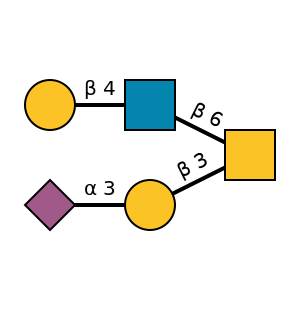

In [14]:
#@markdown # Step 4a: Analyse the MS2 spectrum of a glycan predicted above

#@markdown ### Enter the **prediction ID** of the glycan prediction you wish to analyse:
ID = 6 #@param {type:"integer"}

#@markdown ### Enter the **mass threshold** to use when searching for fragments (in Dalton):
threshold = 0.5 #@param {type:"number"}

#@markdown ## Click and drag to zoom in on the spectrum. Hover over each bin to display the predicted MS2 fragment.
#@markdown **Note:** Each MS2 spectrum produced this way is also saved as an interactive html file locally in the `Files` tab on the left
from bokeh.models import HoverTool
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()

rows = []
parent_glycan = df_out.iloc[ID,0][0][0]
spectrum = sorted(spectra_out[ID].items())
masses = [x[0] for x in spectrum]
intensities = [x[1] for x in spectrum]
charge = display_df.at[ID,'charge']
main_annotations = CandyCrumbs(parent_glycan,masses,threshold,charge = charge,simplify=True)
                              #  ,label_mass = label_mass +1)
sorted_masses = [x for x in main_annotations]
frags = [main_annotations[x]['Domon-Costello nomenclatures'][0] if main_annotations[x] else [] for x in main_annotations]
theoretical_masses = [main_annotations[x]['Theoretical fragment masses'][0] if main_annotations[x] else [] for x in main_annotations]
svgs_in = [GlycoDraw(domon_costello_to_fragIUPAC(parent_glycan,x)).as_svg() if x else '' for x in frags]
charges = [main_annotations[x]['Fragment charges'][0] if main_annotations[x] else [] for x in main_annotations]
ppm_error_list = []
for theoretical_mass,obs_mass,fragment_charge in zip(theoretical_masses,sorted_masses,charges):
  if theoretical_mass == []:
    ppm_error_list.append([])
    continue
  if abs(fragment_charge) >1:
    theoretical_mass = theoretical_mass/abs(fragment_charge) + (1/fragment_charge)
  ppm_error_list.append(round(abs(calculate_ppm_error(theoretical_mass,obs_mass)),2))
rows = []
for i,mass in enumerate(masses):
  row_dict = {'mass':mass,'intensity':intensities[i],'frag':domon_costello_to_html(frags[i]),'img':svgs_in[i], 'charge':charges[i],'ppm_error':ppm_error_list[i]}
  rows.append(row_dict)
row_df = pd.DataFrame(rows)


# MS2_output_name = filename.split('.')[0] + '_ID_' + str(ID) + '_MS2_spectrum'
# output_file(f"{MS2_output_name}.html")

TOOLS = "hover,save,box_zoom,reset,wheel_zoom"
TOOLTIPS = """
<div>
m/z: @mass{1.11}<br>
Domon Costello: @frag<br>
charge: @charge<br>
ppm error: @ppm_error{1.11}<br>
@img{safe}
</div>
"""
p = figure(plot_width=2000, plot_height=600, y_axis_label="normalised intensity",x_axis_label="m/z", tools=TOOLS, tooltips=TOOLTIPS)

p.vbar(x='mass', bottom=0, top='intensity', width=0.1, source=row_df)
hover = p.select(dict(type=HoverTool))
hover.mode='mouse'
show(p)
display(GlycoDraw(parent_glycan))
HTML('<br>'*3)

In [15]:
#@markdown # Step 4b: Show more possible MS2 structures of a glycan predicted above

#@markdown ### Enter the **prediction ID** of the glycan prediction you wish to analyse:
ID = 6 #@param {type:"integer"}

#@markdown ### Enter the **mass threshold** to use when searching for fragments (in Dalton):
threshold = 0.5 #@param {type:"number"}

#@markdown ### Enter the **number of fragments** you wish to analyse:
topk_fragments = 10 #@param {type:"integer"}

parent_glycan = df_out.iloc[ID,0][0][0]
if '{' in parent_glycan:
  raise Exception('Unfortunately structures with undefined topologies are not currently supported.')
parent_image = GlycoDraw(parent_glycan).as_svg()
alt_preds = [x[0] for x in df_out.iloc[ID,0] if x[0]!= display_df.iloc[0,1]]
alt_pred_probs = [x[1] for x in df_out.iloc[ID,0] if x[0] in alt_preds]
main_fragments = {k:v for k, v in sorted(spectra_out[ID].items(), key = lambda item: item[1],reverse=True)}
main_peaks = [x for x in list(main_fragments.keys())][:topk_fragments]
if len(main_peaks) == 0:
  raise Exception('Unfortunately no MS2 peaks were found.')
main_intensities = [x for x in list(main_fragments.values())][:topk_fragments]
idx = np.argsort(main_peaks)
main_peaks = [main_peaks[x] for x in idx]
main_intensities = [main_intensities[x] for x in idx]

if modification == 'custom':
  label_mass = mass_tag
else:
  label_mass = modification_mass_dict[modification]

try:
  all_annotations = CandyCrumbs(parent_glycan,main_peaks,threshold,simplify=False,charge = display_df.at[ID,'charge'])
  primary_annotations = CandyCrumbs(parent_glycan,main_peaks,threshold,simplify=True,charge = display_df.at[ID,'charge'])
except:
  print('Unfortunately the MS2 fragments for this structure cannot be calculated, please try another.')

frag_DC_list = []
frags_img_list = []
ppm_error_list = []
charge_list = []
theoretical_masses2 = []
for i,x in enumerate(all_annotations):
  if all_annotations[x]:
    dc_annotations = all_annotations[x]['Domon-Costello nomenclatures']
    primary_annotation = primary_annotations[x]['Domon-Costello nomenclatures'][0]
    dc_annotations.sort(key=len)
    dc_annotations.insert(0, dc_annotations.pop(dc_annotations.index(primary_annotation)))
    dc_names = "<br>".join([domon_costello_to_html(frag) for frag in dc_annotations])
    frag_DC_list.append('<center>'+dc_names+'</center>')
    fragment_charge = primary_annotations[x]['Fragment charges'][0]
    charge_list.append(fragment_charge)
    theoretical_mass = primary_annotations[x]['Theoretical fragment masses'][0]
    if abs(fragment_charge) >1:
      theoretical_mass = theoretical_mass/abs(fragment_charge) + (1/fragment_charge)
    ppm_error_list.append(round(abs(calculate_ppm_error(theoretical_mass,main_peaks[i])),2))
    theoretical_masses2.append(theoretical_mass)
  else:
    dc_annotations = []
    frag_DC_list.append('<center>'+'No fragments found'+'</center>')
    ppm_error_list.append('')
    charge_list.append('')
  frag_IUPAC_list = [domon_costello_to_fragIUPAC(parent_glycan,frag) for frag in dc_annotations]
  frags_img_list.append([GlycoDraw(x).as_svg() for x in frag_IUPAC_list])
  # [[GlycoDraw(x).as_svg() for x in shot if GlycoDraw(x)] for shot in alt_preds]
frag_table = pd.DataFrame(columns=['fragment_mass','normalised_intensity','possible_annotations','possible_snfg_annotations'])
frag_table['fragment_mass'] = main_peaks
main_intensities = [round(x,2) for x in main_intensities]
frag_table['normalised_intensity'] = main_intensities
frag_table['possible_annotations'] = frag_DC_list
frag_table['possible_snfg_annotations'] = frags_img_list
frag_table['ppm_error'] = ppm_error_list
frag_table['fragment_charge'] = charge_list
frag_table = frag_table.sort_values('normalised_intensity',ascending=False)
frag_table[[x for x in frag_table.columns if x!= 'possible_snfg_annotations']] = frag_table[[x for x in frag_table.columns if x != 'possible_snfg_annotations']].astype(str)

MS2_format_dict = {'fragment_mass':format_name,'normalised_intensity':format_name,'possible_annotations':format_name,'possible_snfg_annotations': format_alt_images,'fragment_charge':format_name,'ppm_error':format_name}

frag_table = '<center>'+parent_image+"<br>"+frag_table.to_html(escape=False, formatters=MS2_format_dict)
frag_table = frag_table.replace('<th>', '<th style="font-size: 20px">')
frag_table = new_style + frag_table


# Display HTML table
display(HTML(frag_table))

,fragment_mass,normalised_intensity,possible_annotations,possible_snfg_annotations,ppm_error,fragment_charge
7,860.3304438477567,26.68,"Z2βY2β, M - H2O0,2X3β, M - C2H4O2",,18.18,-1
1,438.650427355949,21.72,"Y2β0,2X3β, M - C2H2O0,2X2α, 0,2A3α, M - C3H8O4",,27.92,-2
3,470.2002972693991,17.57,"C2αZ1α, 2,5A3αY2α, Z2β, 2,5A3αZ2α, Y2β, 2,5A3αY1α, 2,5A3α, M - H2O",,104.96,-1
2,439.1649664912768,11.74,No fragments found,,,
4,569.223991129145,8.82,"Z1αY2α, Z2βZ2α, Y2βY1α, M - H2OY2α, Y2β, M - H2O",,8.07,-1
8,878.1883089952557,7.44,"Y2β0,2X3β, M - C2H2O",,156.03,-1
0,290.02321017907116,7.37,"B1αC1α, M - H2O1,3A2α, M - C2H4O22,4A2α, M - C2H4O2Z2β, Z1α, 2,5A3α",,221.97,-1
6,749.4252576276232,6.54,"Y2αY2β, 2,5A3α, M - CH2O",,190.19,-1
5,675.1415139911574,6.22,Y1β,,154.66,-1
9,878.3818947671897,5.99,"Y2β0,2X3β, M - C2H2O",,64.38,-1
